# Detección de enfermedades respiratorias

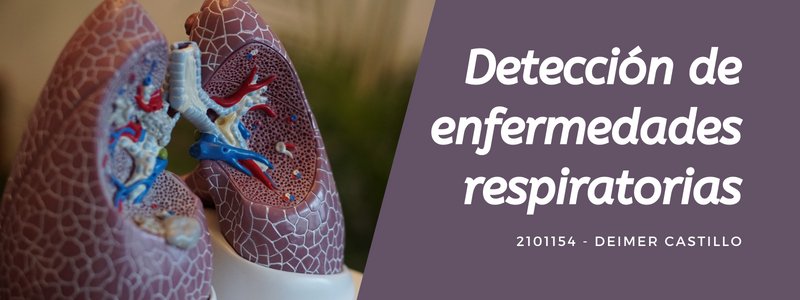



## Objetivo:
- Construir un modelo que clasifique enfermedades respiratorias a partir de características de grabaciones de sonidos respiratorios.

## Dataset:
- El dataset consta de un total de 5,5 horas de grabaciones que contienen 6.898 ciclos respiratorios, de los cuales 1.864 contienen crujidos, 886 contienen silbidos y 506 contienen tanto crujidos como silbidos, en 920 muestras de audio anotadas de 126 pacientes.

- Los ciclos fueron anotados por expertos en respiración para determinar si incluían crujidos, sibilancias, una combinación de ellas o ningún sonido respiratorio adverso.

- Las grabaciones se recogieron con equipos heterogéneos y su duración osciló entre 10 y 90 segundos. También se indican las localizaciones torácicas de las que se obtuvieron las grabaciones. Los niveles de ruido en algunos ciclos respiratorios son elevados, lo que simula las condiciones de la vida real.


## Load dataset, libraries and functions

### Google Drive

In [1]:
# Mount google drive folder and change working directory
from google.colab import drive
drive.mount('/content/drive')
%cd 'drive/MyDrive/IA-1/ai1-project'

Mounted at /content/drive
/content/drive/MyDrive/IA-1/ai1-project


### Kaggle API

In [ ]:
# Using kaggle API
! echo '{"username":"deimercastillo","key":"030249763ac6902170d2f503b807ddc2"}' > kaggle.json
! pip -q install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download vbookshelf/respiratory-sound-database
! unzip -q respiratory-sound-database.zip -d dataset

100% 3.68G/3.69G [00:36<00:00, 102MB/s]
100% 3.69G/3.69G [00:36<00:00, 108MB/s]


### Libraries

In [2]:
## Required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import os
import librosa as lb
import librosa.display
import soundfile as sf

import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight


### Functions

In [3]:
# functions

def filenameInfo(filename):
    return filename.split('_')

def slice_data(raw_data, start, end, sample_rate = 22050):
    max_ind = len(raw_data) 
    start_ind = min(int(start * sample_rate), max_ind)
    end_ind = min(int(end * sample_rate), max_ind)
    return raw_data[start_ind: end_ind]

def extractId(filename):
    return filename.split('_')[0]

def getFeatures(path):
    soundArr,sample_rate = lb.load(path)
    mfcc = lb.feature.mfcc(y = soundArr, sr = sample_rate)
    cstft = lb.feature.chroma_stft(y = soundArr, sr = sample_rate)
    mSpec = lb.feature.melspectrogram(y = soundArr, sr = sample_rate)
    return mfcc,cstft,mSpec


## Preprocessing

### Patient information

In [4]:
# Patient Info
patient_data = pd.read_csv('dataset/Respiratory_Sound_Database/Respiratory_Sound_Database/patient_diagnosis.csv', names = ['patientId', 'diagnosis'])
patient_data.head()
diseases = patient_data['diagnosis'].unique()
diseases.shape

(8,)

In [5]:
print(patient_data['patientId'].unique().shape)

(126,)


In [6]:
print(diseases)

['URTI' 'Healthy' 'Asthma' 'COPD' 'LRTI' 'Bronchiectasis' 'Pneumonia'
 'Bronchiolitis']


### Audio Information

In [11]:
# Audio file info
audio_info = pd.read_csv('dataset/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/107_2b3_Lr_mc_AKGC417L.txt', sep = '\t')
audio_info

,0.887,2.601,0,0.1
0,2.601,5.327,1,0
1,5.327,7.923,1,0
2,7.923,10.530,1,0
3,10.530,13.196,1,0
4,13.196,15.565,1,0
5,15.565,18.054,1,0
6,18.054,19.101,1,0


In [12]:
# Getting file list
audio_text_path = 'dataset/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/'
files = [s.split('.')[0] for s in os.listdir(path = audio_text_path) if '.txt' in s]
files[:5]

['160_1b3_Ar_mc_AKGC417L',
 '160_1b3_Al_mc_AKGC417L',
 '160_1b4_Pl_mc_AKGC417L',
 '160_1b4_Al_mc_AKGC417L',
 '160_1b4_Tc_mc_AKGC417L']

In [13]:
filenameInfo(files[12])

['160', '2b4', 'Pr', 'mc', 'AKGC417L']

In [14]:
# file name info dataframe

files_data = []
for file in files:
    data = pd.read_csv(audio_text_path + '/' + file + '.txt', sep='\t', names=['start', 'end', 'crackles', 'wheezes'])

    name_data = filenameInfo(file)
    data['patientId'] = name_data[0]
    data['mode'] = name_data[-2]
    data['filename'] = file
    files_data.append(data)
files_df = pd.concat(files_data)
files_df.reset_index()
files_df.head()


,start,end,crackles,wheezes,patientId,mode,filename
0,1.862,5.718,0,1,160,mc,160_1b3_Ar_mc_AKGC417L
1,5.718,9.725,0,1,160,mc,160_1b3_Ar_mc_AKGC417L
2,9.725,13.614,0,1,160,mc,160_1b3_Ar_mc_AKGC417L
3,13.614,17.671,0,1,160,mc,160_1b3_Ar_mc_AKGC417L
4,17.671,19.541,0,0,160,mc,160_1b3_Ar_mc_AKGC417L


In [15]:
patient_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 126 entries, 0 to 125
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   patientId  126 non-null    int64 
 1   diagnosis  126 non-null    object
dtypes: int64(1), object(1)
memory usage: 2.1+ KB


In [16]:
files_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6898 entries, 0 to 1
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   start      6898 non-null   float64
 1   end        6898 non-null   float64
 2   crackles   6898 non-null   int64  
 3   wheezes    6898 non-null   int64  
 4   patientId  6898 non-null   object 
 5   mode       6898 non-null   object 
 6   filename   6898 non-null   object 
dtypes: float64(2), int64(2), object(3)
memory usage: 431.1+ KB


In [17]:
# Change column datatype
patient_data['patientId'] = patient_data['patientId'].astype('int32')
files_df['patientId'] = files_df['patientId'].astype('int32')

In [18]:
# Merge dataframes
data = pd.merge(files_df, patient_data, on = 'patientId')
data.head()

,start,end,crackles,wheezes,patientId,mode,filename,diagnosis
0,1.862,5.718,0,1,160,mc,160_1b3_Ar_mc_AKGC417L,COPD
1,5.718,9.725,0,1,160,mc,160_1b3_Ar_mc_AKGC417L,COPD
2,9.725,13.614,0,1,160,mc,160_1b3_Ar_mc_AKGC417L,COPD
3,13.614,17.671,0,1,160,mc,160_1b3_Ar_mc_AKGC417L,COPD
4,17.671,19.541,0,0,160,mc,160_1b3_Ar_mc_AKGC417L,COPD


### Audio slicing

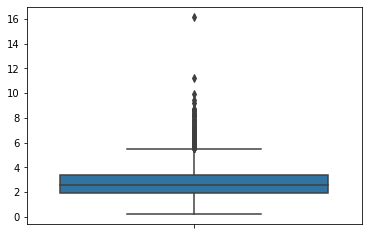

In [ ]:
sns.boxplot(y=(data.end-data.start))

In [ ]:
# Output folder
os.makedirs('processed_audio_files')

In [ ]:
# Slicing audio files
i = 0
c = 0

for index,row in data.iterrows():
    maxLen = 6
    start = row['start']
    end = row['end']
    filename = row['filename']
    
    #If len > maxLen , change it to maxLen
    if end-start>maxLen:
        end=start+maxLen
    
    audio_file_loc = audio_text_path + filename + '.wav'
    
    if index > 0:
        #check if more cycles exits for same patient if so then add i to change filename
        if data.iloc[index-1]['filename']==filename:
            i+=1
        else:
            i=0
    filename= filename + '_' + str(i) + '.wav'
    
    save_path = 'processed_audio_files/' + filename
    c += 1
    
    audioArr, sampleRate = lb.load(audio_file_loc)
    pureSample = slice_data(audioArr,start,end,sampleRate)
    
    #pad audio if pureSample len < max_len
    reqLen = 6 * sampleRate
    padded_data = lb.util.pad_center(pureSample, reqLen)
    
    sf.write(file = save_path, data = padded_data, samplerate = sampleRate)

print('Total Files Processed: ',c)

Total Files Processed:  6898


## Test/Train Dataframe




In [19]:
path='processed_audio_files/'

length=len(os.listdir(path))
index=range(length)
i = 0

files_df=pd.DataFrame(index = index, columns=['patientId','filename'])

for f in os.listdir(path):
    files_df.iloc[i]['patientId']=extractId(f)
    files_df.iloc[i]['filename']=f
    i+=1

files_df.head()

,patientId,filename
0,204,204_7p5_Pr_mc_AKGC417L_3.wav
1,204,204_7p5_Pr_mc_AKGC417L_4.wav
2,204,204_7p5_Pr_mc_AKGC417L_5.wav
3,204,204_7p5_Pr_mc_AKGC417L_6.wav
4,204,204_7p5_Tc_mc_AKGC417L_0.wav


In [20]:
files_df['patientId'] = files_df['patientId'].astype('int64')

In [21]:
data = pd.merge(files_df, patient_data, on = 'patientId')
data.head()

,patientId,filename,diagnosis
0,204,204_7p5_Pr_mc_AKGC417L_3.wav,COPD
1,204,204_7p5_Pr_mc_AKGC417L_4.wav,COPD
2,204,204_7p5_Pr_mc_AKGC417L_5.wav,COPD
3,204,204_7p5_Pr_mc_AKGC417L_6.wav,COPD
4,204,204_7p5_Tc_mc_AKGC417L_0.wav,COPD


In [22]:
data.shape

(6898, 3)

In [23]:
# Train/Set split
X_train, X_test, y_train, y_test = train_test_split(data, data['diagnosis'], stratify = data['diagnosis'], test_size=0.2)

In [24]:
X_train.head()

,patientId,filename,diagnosis
1051,226,226_1b1_Pl_sc_LittC2SE_10.wav,Pneumonia
3155,156,156_5b3_Pr_mc_AKGC417L_4.wav,COPD
3810,164,164_1b1_Ll_sc_Meditron_5.wav,URTI
5355,130,130_2b2_Pr_mc_AKGC417L_1.wav,COPD
3954,167,167_1b1_Al_sc_Meditron_1.wav,Bronchiolitis


In [25]:
y_test.head()

2389    COPD
902     COPD
3053    COPD
2562    COPD
5862    COPD
Name: diagnosis, dtype: object

In [26]:
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

In [27]:
# One hot encoder
y_train_ohe = tf.keras.utils.to_categorical(y_train, num_classes = 8)
y_test_ohe = tf.keras.utils.to_categorical(y_test, num_classes = 8)

print(y_train_ohe.shape, y_test_ohe.shape)

(5518, 8) (1380, 8)


In [28]:
# Class weights
y_integers = np.argmax(y_train_ohe, axis=1)
class_weights = compute_class_weight(class_weight = 'balanced', classes = np.unique(y_integers), y = y_integers)
d_class_weights = dict(enumerate(class_weights))

## Audio Feature Extraction

- MFCC
- Chroma
- MSPEC



[Text(0.5, 1.0, 'Mel-Spec')]

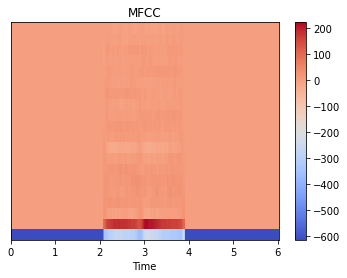

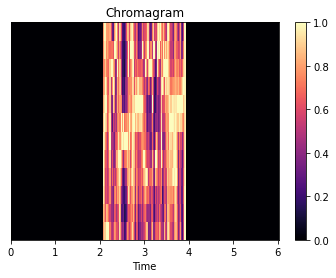

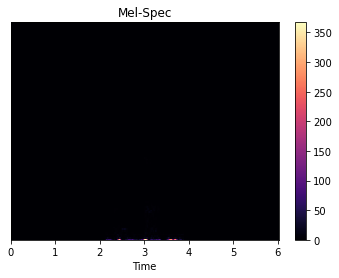

In [29]:
# Examples

file = path + X_train.iloc[1337].filename
sound,sample_rate = lb.load(file)
mfcc = lb.feature.mfcc(y=sound, sr=sample_rate)
cstft = lb.feature.chroma_stft(y=sound, sr=sample_rate)
mspec = lb.feature.melspectrogram(y=sound, sr=sample_rate)

fig, ax = plt.subplots()
img = librosa.display.specshow(mfcc, x_axis='time', ax=ax)
fig.colorbar(img, ax=ax)
ax.set(title='MFCC')

fig, ax = plt.subplots()
img = librosa.display.specshow(cstft, x_axis='time', ax=ax)
fig.colorbar(img, ax=ax)
ax.set(title='Chromagram')

fig, ax = plt.subplots()
img = librosa.display.specshow(mspec, x_axis='time', ax=ax)
fig.colorbar(img, ax=ax)
ax.set(title='Mel-Spec')

In [30]:
# Train set features

mfcc,cstft,mSpec=[],[],[]

for idx,row in X_train.iterrows():
    p = path + row['filename']
    m, c, ms = getFeatures(p)
    mfcc.append(m)
    cstft.append(c)
    mSpec.append(ms)
    
mfcc_train=np.array(mfcc)
cstft_train=np.array(cstft)
mspec_train=np.array(mSpec)

/usr/local/lib/python3.7/dist-packages/librosa/core/pitch.py:153: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn("Trying to estimate tuning from empty frequency set.")


In [31]:
# Test set features

mfcc,cstft,mSpec=[],[],[]

for idx,row in X_test.iterrows():
    p = path + row['filename']
    m, c, ms = getFeatures(p)
    mfcc.append(m)
    cstft.append(c)
    mSpec.append(ms)
    
mfcc_test=np.array(mfcc)
cstft_test=np.array(cstft)
mspec_test=np.array(mSpec)

In [32]:
# Normalize train/test
mfcc_train = mfcc_train.astype('float32')/255
cstft_train = cstft_train.astype('float32')/255
mspec_train = mspec_train.astype('float32')/255

mfcc_test = mfcc_test.astype('float32')/255
cstft_test = cstft_test.astype('float32')/255
mspec_test = mspec_test.astype('float32')/255

### CNN Input layer shapes

In [33]:
# mfcc model
mfcc_test.shape

(1380, 20, 259)

In [34]:
# cstft model
cstft_test.shape

(1380, 12, 259)

In [35]:
# mspec model
mspec_test.shape

(1380, 128, 259)

## CNN models


## MFCC

In [36]:
# mfcc model

mfcc_model = tf.keras.models.Sequential()
mfcc_model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(20,259,1)))
mfcc_model.add(tf.keras.layers.MaxPooling2D((2, 2)))
mfcc_model.add(tf.keras.layers.Flatten())
mfcc_model.add(tf.keras.layers.Dense(64, activation='relu'))
mfcc_model.add(tf.keras.layers.Dense(8, activation='softmax'))
mfcc_model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 20, 259, 32)       320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 10, 129, 32)      0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 41280)             0         
                                                                 
 dense (Dense)               (None, 64)                2641984   
                                                                 
 dense_1 (Dense)             (None, 8)                 520       
                                                                 
Total params: 2,642,824
Trainable params: 2,642,824
Non-trainable params: 0
______________________________________________

In [39]:
# Training
mfcc_model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.005), #momentum=0.5, decay=0.0004), 
              loss='categorical_crossentropy',
              metrics=['accuracy'])

mfcc_history = mfcc_model.fit(mfcc_train, y_train_ohe, epochs=25, validation_data=(mfcc_test, y_test_ohe))

Epoch 1/25
173/173 [==============================] - 13s 75ms/step - loss: 0.4513 - accuracy: 0.8287 - val_loss: 0.4765 - val_accuracy: 0.8268
Epoch 2/25
173/173 [==============================] - 12s 68ms/step - loss: 0.4165 - accuracy: 0.8364 - val_loss: 0.4588 - val_accuracy: 0.8399
Epoch 3/25
173/173 [==============================] - 12s 68ms/step - loss: 0.4040 - accuracy: 0.8422 - val_loss: 0.4435 - val_accuracy: 0.8522
Epoch 4/25
173/173 [==============================] - 12s 68ms/step - loss: 0.3936 - accuracy: 0.8481 - val_loss: 0.4410 - val_accuracy: 0.8304
Epoch 5/25
173/173 [==============================] - 12s 68ms/step - loss: 0.3848 - accuracy: 0.8489 - val_loss: 0.4167 - val_accuracy: 0.8449
Epoch 6/25
173/173 [==============================] - 12s 68ms/step - loss: 0.3774 - accuracy: 0.8545 - val_loss: 0.4164 - val_accuracy: 0.8558
Epoch 7/25
173/173 [==============================] - 12s 68ms/step - loss: 0.3720 - accuracy: 0.8581 - val_loss: 0.4169 - val_accuracy:

44/44 [==============================] - 1s 20ms/step - loss: 0.3584 - accuracy: 0.8746
Test accuracy: 0.8746376633644104
Test loss: 0.35836702585220337


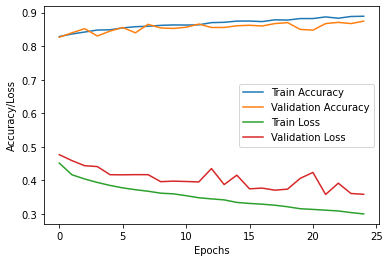

In [40]:
# Evaluating

plt.plot(mfcc_history.history['accuracy'], label='Train Accuracy')
plt.plot(mfcc_history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(mfcc_history.history['loss'], label='Train Loss')
plt.plot(mfcc_history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy/Loss')
plt.legend()

test_loss, test_acc = mfcc_model.evaluate(mfcc_test, y_test_ohe)
print('Test accuracy:', test_acc)
print('Test loss:', test_loss)

## Chroma

In [41]:
# chroma_model

cstft_model =  tf.keras.models.Sequential()
cstft_model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(12,259,1)))
cstft_model.add(tf.keras.layers.MaxPooling2D((2, 2)))
cstft_model.add(tf.keras.layers.Flatten())
cstft_model.add(tf.keras.layers.Dense(64, activation='relu'))
cstft_model.add(tf.keras.layers.Dense(8, activation='softmax'))
cstft_model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 12, 259, 32)       320       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 129, 32)       0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 24768)             0         
                                                                 
 dense_2 (Dense)             (None, 64)                1585216   
                                                                 
 dense_3 (Dense)             (None, 8)                 520       
                                                                 
Total params: 1,586,056
Trainable params: 1,586,056
Non-trainable params: 0
____________________________________________

In [43]:
# Training
cstft_model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.005), 
              loss='categorical_crossentropy',
              metrics=['accuracy'])

cstft_history = cstft_model.fit(cstft_train, y_train_ohe, epochs=25, validation_data=(cstft_test, y_test_ohe))

Epoch 1/25
173/173 [==============================] - 10s 57ms/step - loss: 1.8539 - accuracy: 0.8037 - val_loss: 1.6425 - val_accuracy: 0.8333
Epoch 2/25
173/173 [==============================] - 7s 41ms/step - loss: 1.4758 - accuracy: 0.8329 - val_loss: 1.3257 - val_accuracy: 0.8333
Epoch 3/25
173/173 [==============================] - 7s 41ms/step - loss: 1.2012 - accuracy: 0.8329 - val_loss: 0.9758 - val_accuracy: 0.8333
Epoch 4/25
173/173 [==============================] - 7s 41ms/step - loss: 0.7816 - accuracy: 0.8329 - val_loss: 0.7423 - val_accuracy: 0.8333
Epoch 5/25
173/173 [==============================] - 8s 48ms/step - loss: 0.7379 - accuracy: 0.8329 - val_loss: 0.7303 - val_accuracy: 0.8333
Epoch 6/25
173/173 [==============================] - 7s 41ms/step - loss: 0.7314 - accuracy: 0.8329 - val_loss: 0.7271 - val_accuracy: 0.8333
Epoch 7/25
173/173 [==============================] - 7s 41ms/step - loss: 0.7296 - accuracy: 0.8329 - val_loss: 0.7260 - val_accuracy: 0.833

44/44 [==============================] - 1s 14ms/step - loss: 0.7252 - accuracy: 0.8333
Test accuracy: 0.8333333134651184
Test loss: 0.72516930103302


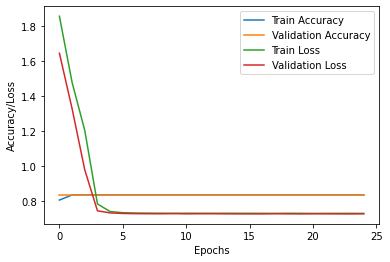

In [44]:
# Evaluating

plt.plot(cstft_history.history['accuracy'], label='Train Accuracy')
plt.plot(cstft_history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(cstft_history.history['loss'], label='Train Loss')
plt.plot(cstft_history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy/Loss')
plt.legend()

test_loss, test_acc = cstft_model.evaluate(cstft_test, y_test_ohe)
print('Test accuracy:', test_acc)
print('Test loss:', test_loss)

## MSPEC

In [45]:
# mspec_model

mspec_model =  tf.keras.models.Sequential()
mspec_model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(128,259,1)))
mspec_model.add(tf.keras.layers.MaxPooling2D((2, 2)))
mspec_model.add(tf.keras.layers.Flatten())
mspec_model.add(tf.keras.layers.Dense(64, activation='relu'))
mspec_model.add(tf.keras.layers.Dense(8, activation='softmax'))
mspec_model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 128, 259, 32)      320       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 64, 129, 32)      0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 264192)            0         
                                                                 
 dense_4 (Dense)             (None, 64)                16908352  
                                                                 
 dense_5 (Dense)             (None, 8)                 520       
                                                                 
Total params: 16,909,192
Trainable params: 16,909,192
Non-trainable params: 0
__________________________________________

In [49]:
# Training
mspec_model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.005), 
              loss='categorical_crossentropy',
              metrics=['accuracy'])

mspec_history = mspec_model.fit(mspec_train, y_train_ohe, epochs=25, validation_data=(mspec_test, y_test_ohe))

Epoch 1/25
173/173 [==============================] - 70s 401ms/step - loss: 0.5836 - accuracy: 0.8329 - val_loss: 0.5938 - val_accuracy: 0.8333
Epoch 2/25
173/173 [==============================] - 70s 406ms/step - loss: 0.5626 - accuracy: 0.8329 - val_loss: 0.5844 - val_accuracy: 0.8333
Epoch 3/25
173/173 [==============================] - 70s 403ms/step - loss: 0.5509 - accuracy: 0.8329 - val_loss: 0.5747 - val_accuracy: 0.8333
Epoch 4/25
173/173 [==============================] - 71s 412ms/step - loss: 0.5397 - accuracy: 0.8329 - val_loss: 0.5706 - val_accuracy: 0.8333
Epoch 5/25
173/173 [==============================] - 70s 407ms/step - loss: 0.5305 - accuracy: 0.8329 - val_loss: 0.5670 - val_accuracy: 0.8333
Epoch 6/25
173/173 [==============================] - 72s 414ms/step - loss: 0.5240 - accuracy: 0.8336 - val_loss: 0.5628 - val_accuracy: 0.8333
Epoch 7/25
173/173 [==============================] - 71s 409ms/step - loss: 0.5172 - accuracy: 0.8353 - val_loss: 0.5643 - val_ac

44/44 [==============================] - 5s 114ms/step - loss: 0.5485 - accuracy: 0.8319
Test accuracy: 0.8318840861320496
Test loss: 0.5485381484031677


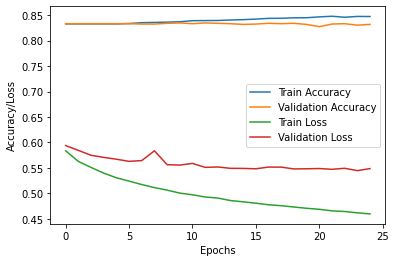

In [50]:
# Evaluating

plt.plot(mspec_history.history['accuracy'], label='Train Accuracy')
plt.plot(mspec_history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(mspec_history.history['loss'], label='Train Loss')
plt.plot(mspec_history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy/Loss')
plt.legend()

test_loss, test_acc = mspec_model.evaluate(mspec_test, y_test_ohe)
print('Test accuracy:', test_acc)
print('Test loss:', test_loss)